<h1>Segmentez les clients d'un site d'e-commerce - Partie 3: Simulation</h1>

* [1. Préparation des données et modules](#10)
    * [1.1 Chargements des modules](#11)
    * [1.2 Chargement des données](#12)
    * [1.3 Conversion au format Datetime](#13)
* [2. Sélection des données pour la modélisation](#20)
* [3. Modelisation Initiale](#30)
* [4. Simulation](#40)

<h1>1. Préparation des données et modules</h1><a class="anchor" id="10"></a>
<h2>1.1 Chargements des modules</h2><a class="anchor" id="11"></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

from datetime import datetime as dt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

<h2>1.2 Chargement des données</h2><a class="anchor" id="12"></a>

In [2]:
df = pd.read_csv('olist.csv')
df.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,estimated_time,total_time,delta_time,payment_type,payment_value,customer_unique_id,customer_city,customer_state,review_score,geolocation_lat,geolocation_lng
23035,13ff8a02b63113dd72976dab2e01b171,de0af4a54889db8e1d4317a8bea43a25,delivered,2017-05-10 12:57:43,2017-05-19 12:55:55,2017-05-30,19,8.0,-11.0,credit_card,85.14,b9d637448a10f135a21ae39465ad6445,santo antonio de padua,RJ,5.0,-21.539284,-42.185547
61340,212754a30f758c661afd6430bc7841fc,1dc00a26f0c615d12cf874964e187c14,delivered,2018-06-30 20:01:17,2018-07-09 11:51:14,2018-07-24,23,8.0,-15.0,credit_card,103.26,aad9e42d77152c08c86c7313709b86b3,cachoeiro de itapemirim,ES,5.0,-20.843418,-41.116058
42897,65f9be44b39d121b9f03120ae4ceef73,b83aa8732c6dcaf653e111d52ebc91f1,shipped,2018-01-04 16:21:45,NaN,2018-01-31,26,NaN,NaN,boleto,60.00,42d2b957a53f0240c81dee35a2463059,goiania,GO,1.0,-16.684467,-49.314289
10027,77acb3b32ab623aaf525b52006d0c142,9be907cf929fd53da43778102239bbaa,delivered,2018-01-23 16:29:22,2018-02-15 00:07:36,2018-03-01,36,22.0,-14.0,credit_card,43.69,f8bbe7aad2046c42040bd68a76d3a3fc,campo grande,MS,5.0,-20.418042,-54.641389
28569,44aec9c2be37dd0f0b954562c94ccfec,eb1f5775cb6c152c959d5a76a8204baa,delivered,2017-09-26 14:23:47,2017-10-03 18:23:40,2017-10-20,23,7.0,-16.0,credit_card,168.29,4f8cc6471488ecd895f2073b868929dd,macae,RJ,5.0,-22.381727,-41.778117


<h2>1.3 Conversion au format datetime</h2><a class="anchor" id="13"></a>

In [3]:
datetime_cols = [
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in datetime_cols:
    df[col] = pd.to_datetime(df[col])
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99440 entries, 0 to 99439
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99440 non-null  object        
 1   customer_id                    99440 non-null  object        
 2   order_status                   99440 non-null  object        
 3   order_purchase_timestamp       99440 non-null  datetime64[ns]
 4   order_delivered_customer_date  96475 non-null  datetime64[ns]
 5   order_estimated_delivery_date  99440 non-null  datetime64[ns]
 6   estimated_time                 99440 non-null  int64         
 7   total_time                     96475 non-null  float64       
 8   delta_time                     96475 non-null  float64       
 9   payment_type                   99440 non-null  object        
 10  payment_value                  99440 non-null  float64       
 11  customer_unique

<h2>1.4 Sélection des données</h2><a class="anchor" id="14"></a>

In [4]:
status_filter = (df['order_status'].isin(['delivered', 'shipped']))

df = df[status_filter].copy()

df.shape

(97584, 17)

In [5]:
df['order_delivered_customer_date'].fillna(value=df['order_estimated_delivery_date'], inplace=True)

df['review_score'].fillna(value=5, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97584 entries, 0 to 99439
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97584 non-null  object        
 1   customer_id                    97584 non-null  object        
 2   order_status                   97584 non-null  object        
 3   order_purchase_timestamp       97584 non-null  datetime64[ns]
 4   order_delivered_customer_date  97584 non-null  datetime64[ns]
 5   order_estimated_delivery_date  97584 non-null  datetime64[ns]
 6   estimated_time                 97584 non-null  int64         
 7   total_time                     96469 non-null  float64       
 8   delta_time                     96469 non-null  float64       
 9   payment_type                   97584 non-null  object        
 10  payment_value                  97584 non-null  float64       
 11  customer_unique_id  

C:\Users\apetit\AppData\Local\Temp\ipykernel_12376\3088779830.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['order_delivered_customer_date'].fillna(value=df['order_estimated_delivery_date'], inplace=True)
C:\Users\apetit\AppData\Local\Temp\ipykernel_12376\3088779830.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

In [6]:
display(df['order_delivered_customer_date'].min())
display(df['order_delivered_customer_date'].max())

Timestamp('2016-10-11 13:46:32')

Timestamp('2018-10-17 13:22:46')

Nous allons supprimer les données avant le 1er Janvier 2017 pour avoir des données plus constantes

In [7]:
min_date = dt.strptime("2017-01-01", "%Y-%m-%d")
max_date = dt.strptime("2018-09-30", "%Y-%m-%d")

min_filter = (df['order_delivered_customer_date'] > min_date)
max_filter = (df['order_delivered_customer_date'] < max_date)

df = df[min_filter & max_filter].copy()

Pour notre modelisation, nous n'avons pas besoin de toutes les colonnes. Pour rappel, les colonnes qui ont été utilisées sont:
* `customer_unique_id`
* `payment_value`
* `order_delivered_customer_date`
* `review_score`

`order_id` était utilisée pour compter le nombre de commande par client. Les clients à commande multiple n'étant qu'une minorité, ce paramètre n'a pas été retenu

In [8]:
df = df[['customer_unique_id', 'payment_value', 'order_delivered_customer_date', 'review_score']].copy()
df.shape

(97306, 4)

In [9]:
df['days_since_start'] = (df['order_delivered_customer_date'] - min_date).dt.days

In [10]:
df['days_since_start'].min()

10

In [11]:
df['days_since_start'].max()

634

<h1>3. Modelisation Initiale</h1>

In [12]:
%%time

original_train = df.groupby('customer_unique_id').agg({
    'payment_value': 'sum',
    'order_delivered_customer_date': 'max',
    'review_score': 'mean'
}).reset_index()

CPU times: total: 109 ms
Wall time: 127 ms


In [13]:
original_train['recency'] = (max_date - original_train['order_delivered_customer_date']).dt.days

original_train['satisfied'] = [1 if score >= 4 else 0 for score in original_train['review_score']]

X = original_train[['recency', 'satisfied', 'payment_value']].copy()

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [14]:
original_model = KMeans(n_clusters=4, init='k-means++', random_state=42)
original_model.fit(X_scaled)

centroids = original_model.cluster_centers_

print("Original Model training Completed")

Original Model training Completed


<h1>4. Simulation</h1><br>
La simulation s'effectue grâce à une boucle while qui se déroule en 5 étapes

- Préparation des données

- Sélection des colonnes

- Clusterisation avec le modèle de réference et le nouveau modèle

- Enregistrement des résultats

- Mise à jour du réferentiel de temps

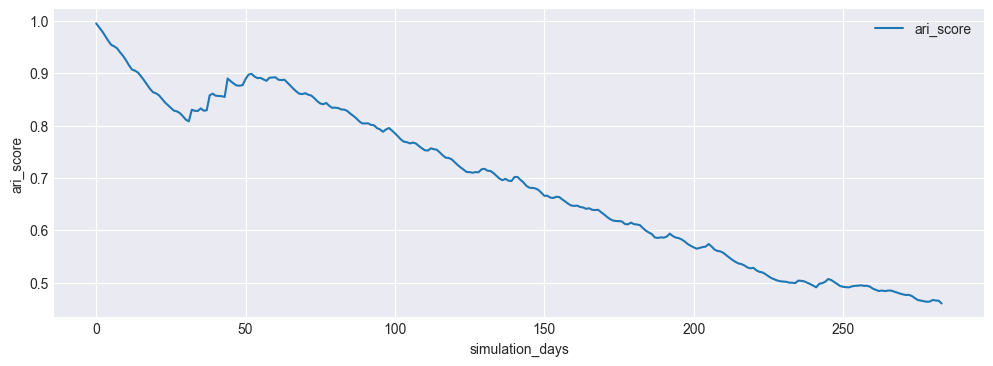

In [19]:
n_days = df['days_since_start'].max()

results = pd.DataFrame(columns=['simulation_days', 'ari_score'])

while n_days > 350:
    
    # 1.Preparation des donnees
    max_days_filter = (df['days_since_start'] <= n_days)
    
    test_df = df[max_days_filter].copy()
    
    test_df = test_df.groupby('customer_unique_id').agg({
        'payment_value': 'sum',
        'order_delivered_customer_date': 'max',
        'review_score': 'mean'
    }).reset_index()
    
    max_date = min_date + pd.Timedelta(days=n_days)
    
    test_df['recency'] = (max_date - test_df['order_delivered_customer_date']).dt.days
    
    test_df['satisfied'] = [1 if score >= 4 else 0 for score in test_df.review_score]
    
    # 2. Selection des colonnes et standardisation
    X = test_df[['recency', 'satisfied', 'payment_value']].copy()
    
    X_scaled = scaler.transform(X)
    
    # 3. Clusterisation avec les deux modeles puis comparasion des resultats
    clusters_0 = original_model.predict(X_scaled)
    
    new_model = KMeans(n_clusters=4, init=centroids, random_state=42)
    
    new_clusters = new_model.fit_predict(X_scaled)
    
    ari_score = adjusted_rand_score(clusters_0, new_clusters)
    
    # 4. Enregistrement du score dans la df results
    simulation_days = 634 - n_days
    
    new_row = {'simulation_days': simulation_days, 'ari_score': ari_score}
    
    l = results.shape[0]
    
    results.loc[l] = new_row
    
    #5. mises a jour du parametre de temps
    n_days -= 1

plt.figure(figsize=(12,4))
sns.lineplot(data=results, x='simulation_days', y='ari_score', label='ari_score')
plt.legend();